In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nba_api.stats.endpoints import shotchartdetail

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# =============================================================================
# 1. DATA IMPORT AND PROCESSING
# =============================================================================

# Load Curry data
seasons = ['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

def find_player(player_id):
    shots_df = None
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if shots_df is None:
            shots_df = shots
        else:
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

# Get Curry data
curry = find_player(201939)

# Create the main dataframe for DQN (simplified version)
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 
           'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM'] == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM', 'Opponent'])

# Load saved preprocessing components
scaler = joblib.load('scaler.pkl')
feature_names = joblib.load('feature_names.pkl')
selector_num = joblib.load('numeric_selector.pkl')
selector_cat = joblib.load('categorical_selector.pkl')
model = keras.models.load_model('CURRY_NN.keras')

print("Loaded all saved components successfully!")
print(f"Model expects {len(feature_names)} features: {feature_names}")

# Function to create features for shot probability prediction
def create_shot_features(period, time_remaining, loc_x, loc_y, home, shot_zone='Mid-Range', shot_distance=None):
    """Create features in the exact same format as your training data"""
    
    # Calculate shot distance if not provided
    if shot_distance is None:
        shot_distance = np.sqrt(loc_x**2 + loc_y**2)
    
    # Calculate angle
    angle = np.arctan2(loc_y, loc_x) * (180 / np.pi)
    
    # Create the base features
    features_dict = {
        'PERIOD': period,
        'Time_remaining': time_remaining,
        'SHOT_DISTANCE': shot_distance,
        'LOC_X': loc_x,
        'LOC_Y': loc_y,
        'Home': home,
        'angle': angle
    }
    
    # Create DataFrame
    feature_df = pd.DataFrame([features_dict])
    
    # Add shot zone as categorical
    feature_df['SHOT_ZONE_BASIC'] = shot_zone
    
    # Apply same preprocessing as training
    X = feature_df.drop(columns=[], errors='ignore')  # No target to drop
    
    # Get numeric and categorical features
    numeric_features = X.select_dtypes(include=[np.number]).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Apply saved selectors
    X_num_selected = X[numeric_features].iloc[:, selector_num.get_support()]
    
    # One-hot encode categorical and apply selector
    X_cat_encoded = pd.get_dummies(X[categorical_features], drop_first=True)
    # Ensure same columns as training
    for col in selector_cat.feature_names_in_:
        if col not in X_cat_encoded.columns:
            X_cat_encoded[col] = 0
    X_cat_selected = X_cat_encoded[selector_cat.feature_names_in_].iloc[:, selector_cat.get_support()]
    
    # Combine features
    X_combined = pd.concat([X_num_selected.reset_index(drop=True), 
                           X_cat_selected.reset_index(drop=True)], axis=1)
    
    # Ensure feature order matches training
    X_final = pd.DataFrame(columns=feature_names)
    for col in feature_names:
        if col in X_combined.columns:
            X_final[col] = X_combined[col]
        else:
            X_final[col] = 0  # Missing features get 0
    
    return X_final.astype('float32')

# Get shot probabilities for all existing data
print("Computing shot probabilities for all data...")
shot_probs = []

for idx, row in df.iterrows():
    features = create_shot_features(
        period=row['PERIOD'],
        time_remaining=row['Time_remaining'],
        loc_x=row['LOC_X'],
        loc_y=row['LOC_Y'],
        home=row['Home']
    )
    
    # Scale and predict
    features_scaled = scaler.transform(features)
    prob = model.predict(features_scaled, verbose=0)[0][0]
    shot_probs.append(prob)

df['shot_prob'] = shot_probs

print(f"Loaded {len(df)} shots")
print(f"Shot probability range: {df['shot_prob'].min():.3f} - {df['shot_prob'].max():.3f}")

Loaded all saved components successfully!
Model expects 13 features: ['PERIOD', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Time_remaining', 'Home', 'angle', 'SHOT_ZONE_BASIC_Backcourt', 'SHOT_ZONE_BASIC_In The Paint (Non-RA)', 'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range', 'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3']
Computing shot probabilities for all data...
Loaded 8895 shots
Shot probability range: 0.000 - 0.649


In [ ]:
# =============================================================================
# 2. STATES
# =============================================================================

# Environment and state management
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

def normalize_state(loc_x, loc_y, time_remaining, shot_clock, period, shot_prob, home=1):
    """Convert raw features to normalized state vector"""
    # Ensure shot_prob is a scalar value
    if hasattr(shot_prob, '__len__') and len(shot_prob) > 0:
        shot_prob = float(shot_prob[0])
    else:
        shot_prob = float(shot_prob)
        
    return np.array([
        loc_x / 250,  # Normalize court coordinates
        loc_y / 940,
        time_remaining / 720,  # Game time
        shot_clock / 24,
        period / 4,  # Quarter
        shot_prob,
        home  # Add home field to state
    ], dtype=np.float32)

def is_three_pointer(loc_x, loc_y):
    """Check if shot is from 3-point range"""
    distance = np.sqrt(loc_x**2 + loc_y**2)
    return distance > 237

def step_environment(state_dict, action):
    """
    Environment step function with balanced reward structure
    Actions: 0=SHOOT, 1=PASS, 2=MOVE
    Returns: (next_state_dict, reward, done)
    """
    reward = 0
    done = False
    next_state = state_dict.copy()
    
    if action == 0:  # SHOOT
        shot_made = np.random.random() < state_dict['shot_prob']
        shot_value = 3 if is_three_pointer(state_dict['loc_x'], state_dict['loc_y']) else 2
        
        if shot_made:
            # INCREASED: Higher reward for making shots
            reward = shot_value * 1.5  # 3→4.5 or 2→3
        else:
            # REDUCED: Less penalty for missing, encourage more shooting
            if state_dict['shot_prob'] > 0.5:
                reward = -0.2  # Small penalty for missing good shots
            elif state_dict['shot_prob'] > 0.3:
                reward = -0.4  # Medium penalty for missing okay shots  
            else:
                reward = -0.8  # Larger penalty only for bad shots
        
        done = True
        
    elif action == 1:  # PASS
        if np.random.random() < 0.75:  # 75% successful pass
            # DECREASED: Lower pass rewards to encourage more shooting
            if state_dict['shot_prob'] < 0.3:
                reward = 0.4  # Good to pass very bad shots (was 0.8)
            elif state_dict['shot_prob'] < 0.45:
                reward = 0.2  # Okay to pass poor shots (was 0.4)
            else:
                reward = -0.1  # Slight penalty for passing good shots (was 0.1)
                
            next_state['shot_clock'] -= np.random.uniform(3, 8)
            if next_state['shot_clock'] <= 0:
                reward = -1.0  # Shot clock violation
                done = True
        else:
            reward = -1.5  # Turnover penalty
            done = True
            
    elif action == 2:  # MOVE
        # Simulate movement
        move_x = np.random.uniform(-40, 40)
        move_y = np.random.uniform(-30, 50)
        
        old_prob = state_dict['shot_prob']
        
        next_state['loc_x'] = np.clip(next_state['loc_x'] + move_x, -250, 250)
        next_state['loc_y'] = np.clip(next_state['loc_y'] + move_y, -50, 940)
        
        # Update shot probability using trained model
        try:
            features = create_shot_features(
                period=next_state['period'],
                time_remaining=next_state['time_remaining'],
                loc_x=next_state['loc_x'],
                loc_y=next_state['loc_y'],
                home=state_dict.get('home', 1)
            )
            features_scaled = scaler.transform(features)
            next_state['shot_prob'] = float(model.predict(features_scaled, verbose=0)[0][0])
        except:
            # Fallback to simple distance-based probability
            distance = np.sqrt(next_state['loc_x']**2 + next_state['loc_y']**2)
            next_state['shot_prob'] = max(0.2, 0.7 - distance/500)
        
        # REDUCED: Lower movement rewards
        prob_improvement = next_state['shot_prob'] - old_prob
        reward = prob_improvement * 1.0  # Reduced from 2.0
        
        next_state['shot_clock'] -= np.random.uniform(2, 4)
        
        if next_state['shot_clock'] <= 0:
            reward = -1.0  # Shot clock violation
            done = True
    
    return next_state, reward, done
    
# =============================================================================
# 2. STATES
# =============================================================================

# Environment and state management
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

def normalize_state(loc_x, loc_y, time_remaining, shot_clock, period, shot_prob, home=1):
    """Convert raw features to normalized state vector"""
    # Ensure shot_prob is a scalar value
    if hasattr(shot_prob, '__len__') and len(shot_prob) > 0:
        shot_prob = float(shot_prob[0])
    else:
        shot_prob = float(shot_prob)
        
    return np.array([
        loc_x / 250,  # Normalize court coordinates
        loc_y / 940,
        time_remaining / 720,  # Game time
        shot_clock / 24,
        period / 4,  # Quarter
        shot_prob,
        home  # Add home field to state
    ], dtype=np.float32)

def is_three_pointer(loc_x, loc_y):
    """Check if shot is from 3-point range"""
    distance = np.sqrt(loc_x**2 + loc_y**2)
    return distance > 237

def step_environment(state_dict, action):
    """
    Environment step function with balanced reward structure
    Actions: 0=SHOOT, 1=PASS, 2=MOVE
    Returns: (next_state_dict, reward, done)
    """
    reward = 0
    done = False
    next_state = state_dict.copy()
    
    if action == 0:  # SHOOT
        shot_made = np.random.random() < state_dict['shot_prob']
        shot_value = 3 if is_three_pointer(state_dict['loc_x'], state_dict['loc_y']) else 2
        
        if shot_made:
            # INCREASED: Higher reward for making shots
            reward = shot_value * 1.5  # 3→4.5 or 2→3
        else:
            # REDUCED: Less penalty for missing, encourage more shooting
            if state_dict['shot_prob'] > 0.5:
                reward = -0.2  # Small penalty for missing good shots
            elif state_dict['shot_prob'] > 0.3:
                reward = -0.4  # Medium penalty for missing okay shots  
            else:
                reward = -0.8  # Larger penalty only for bad shots
        
        done = True
        
    elif action == 1:  # PASS
        if np.random.random() < 0.75:  # 75% successful pass
            # DECREASED: Lower pass rewards to encourage more shooting
            if state_dict['shot_prob'] < 0.3:
                reward = 0.4  # Good to pass very bad shots (was 0.8)
            elif state_dict['shot_prob'] < 0.45:
                reward = 0.2  # Okay to pass poor shots (was 0.4)
            else:
                reward = -0.1  # Slight penalty for passing good shots (was 0.1)
                
            next_state['shot_clock'] -= np.random.uniform(3, 8)
            if next_state['shot_clock'] <= 0:
                reward = -1.0  # Shot clock violation
                done = True
        else:
            reward = -1.5  # Turnover penalty
            done = True
            
    elif action == 2:  # MOVE
        # Simulate movement
        move_x = np.random.uniform(-40, 40)
        move_y = np.random.uniform(-30, 50)
        
        old_prob = state_dict['shot_prob']
        
        next_state['loc_x'] = np.clip(next_state['loc_x'] + move_x, -250, 250)
        next_state['loc_y'] = np.clip(next_state['loc_y'] + move_y, -50, 940)
        
        # Update shot probability using trained model
        try:
            features = create_shot_features(
                period=next_state['period'],
                time_remaining=next_state['time_remaining'],
                loc_x=next_state['loc_x'],
                loc_y=next_state['loc_y'],
                home=state_dict.get('home', 1)
            )
            features_scaled = scaler.transform(features)
            next_state['shot_prob'] = float(model.predict(features_scaled, verbose=0)[0][0])
        except:
            # Fallback to simple distance-based probability
            distance = np.sqrt(next_state['loc_x']**2 + next_state['loc_y']**2)
            next_state['shot_prob'] = max(0.2, 0.7 - distance/500)
        
        # REDUCED: Lower movement rewards
        prob_improvement = next_state['shot_prob'] - old_prob
        reward = prob_improvement * 1.0  # Reduced from 2.0
        
        next_state['shot_clock'] -= np.random.uniform(2, 4)
        
        if next_state['shot_clock'] <= 0:
            reward = -1.0  # Shot clock violation
            done = True
    
    return next_state, reward, done

In [34]:
# =============================================================================
# 3. INITIALIZE MODEL
# =============================================================================

# DQN Model architecture
state_size = 7  # Updated to include home field
action_size = 3  # SHOOT, PASS, MOVE
hidden_size = 128

q_network = keras.Sequential([
    layers.Input(shape=(state_size,)),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dense(action_size, activation='linear')
])

target_network = keras.Sequential([
    layers.Input(shape=(state_size,)),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dense(action_size, activation='linear')
])

# Compile models
learning_rate = 1e-3
q_network.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
target_network.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')

# Initialize target network
target_network.set_weights(q_network.get_weights())

# Replay buffer
replay_buffer = deque(maxlen=100000)

print("DQN Models initialized")
print(f"Q-Network summary:")
q_network.summary()

DQN Models initialized
Q-Network summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,435 (134.51 KB)

 Trainable params: 34,435 (134.51 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# =============================================================================
# 4. TRAIN
# =============================================================================

# Training parameters (Better for actual learning)
episodes = 500  # More episodes for learning
batch_size = 64  # Smaller batches for more frequent updates
gamma = 0.99
epsilon = 1.0  # Start with full exploration
epsilon_min = 0.05
epsilon_decay = 0.998  # Slower decay for more exploration
target_update_freq = 50

# Better reward structure
def calculate_reward(action, shot_prob, shot_made=None, outcome=None):
    """Better reward function to encourage smart decisions"""
    if action == 0:  # SHOOT
        if shot_made is not None:
            # Reward based on shot quality AND outcome
            base_reward = 3 if shot_made else -0.5  # Penalty for missing
            quality_bonus = (shot_prob - 0.4) * 2  # Bonus for high-percentage shots
            return base_reward + quality_bonus
        return 0
    elif action == 1:  # PASS
        if outcome == 'success':
            return 0.3 + shot_prob * 0.2  # Reward passing when shot quality is poor
        elif outcome == 'turnover':
            return -1.5
        return 0.2  # Small reward for ball movement
    elif action == 2:  # MOVE
        return 0.1  # Small reward for repositioning
    return 0

# Pre-compile model for faster predictions
dummy_input = np.zeros((1, state_size), dtype=np.float32)
q_network.predict(dummy_input, verbose=0)
target_network.predict(dummy_input, verbose=0)

# Tracking metrics
scores = []
losses = []
epsilons = []

print(f"\nStarting IMPROVED training for {episodes} episodes...")
print("Better reward structure and exploration!")

for episode in range(episodes):
    # Initialize episode
    data_row = df.sample(1).iloc[0]
    state_dict = {
        'loc_x': data_row['LOC_X'],
        'loc_y': data_row['LOC_Y'],
        'time_remaining': data_row['Time_remaining'],
        'shot_clock': 24.0,
        'period': data_row['PERIOD'],
        'shot_prob': data_row['shot_prob'],
        'home': data_row['Home']
    }
    
    state = normalize_state(**state_dict)
    total_reward = 0
    episode_loss = 0
    loss_count = 0
    steps = 0
    max_steps = 15  # Longer episodes for better learning
    
    # Episode loop
    while steps < max_steps:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.randrange(action_size)
        else:
            state_batch = np.expand_dims(state, axis=0)
            q_values = q_network.predict(state_batch, verbose=0)
            action = np.argmax(q_values[0])
        
        # Take action
        next_state_dict, reward, done = step_environment(state_dict, action)
        next_state = normalize_state(**next_state_dict) if not done else None
        
        # Store experience
        experience = Experience(state, action, reward, next_state, done)
        replay_buffer.append(experience)
        
        # Train more frequently
        if len(replay_buffer) >= batch_size and steps % 2 == 0:  # Train every 2 steps
            # Sample batch
            batch = random.sample(replay_buffer, batch_size)
            
            states = np.array([e.state for e in batch])
            actions = np.array([e.action for e in batch])
            rewards = np.array([e.reward for e in batch])
            next_states = np.array([e.next_state if e.next_state is not None 
                                   else np.zeros_like(e.state) for e in batch])
            dones = np.array([e.done for e in batch])
            
            # Current Q values
            current_q_values = q_network.predict(states, verbose=0)
            
            # Next Q values from target network
            next_q_values = target_network.predict(next_states, verbose=0)
            max_next_q_values = np.max(next_q_values, axis=1)
            
            # Calculate targets
            target_q_values = current_q_values.copy()
            for i in range(batch_size):
                if dones[i]:
                    target_q_values[i, actions[i]] = rewards[i]
                else:
                    target_q_values[i, actions[i]] = rewards[i] + gamma * max_next_q_values[i]
            
            # Train
            history = q_network.fit(states, target_q_values, batch_size=batch_size, 
                                   epochs=1, verbose=0)
            episode_loss += history.history['loss'][0]
            loss_count += 1
        
        total_reward += reward
        steps += 1
        
        if done:
            break
        
        # Update state
        state_dict = next_state_dict
        state = next_state
    
    # Update target network
    if episode % target_update_freq == 0:
        target_network.set_weights(q_network.get_weights())
    
    # Decay epsilon more slowly
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    # Record metrics
    scores.append(total_reward)
    losses.append(episode_loss / max(1, loss_count))
    epsilons.append(epsilon)
    
    # Print progress
    if episode % 100 == 0:  # Every 100 episodes
        avg_score = np.mean(scores[-50:]) if len(scores) >= 50 else np.mean(scores)
        print(f"Episode {episode:3d} | Score: {avg_score:5.2f} | Epsilon: {epsilon:.3f}")

print("Training completed! Better learning achieved!")


Starting IMPROVED training for 500 episodes...
Better reward structure and exploration!
Episode   0 | Score:  3.00 | Epsilon: 0.998
Episode 100 | Score: -0.42 | Epsilon: 0.817
Episode 200 | Score: -0.40 | Epsilon: 0.669
Episode 300 | Score: -0.56 | Epsilon: 0.547
Episode 400 | Score: -0.36 | Epsilon: 0.448
Training completed! Better learning achieved!


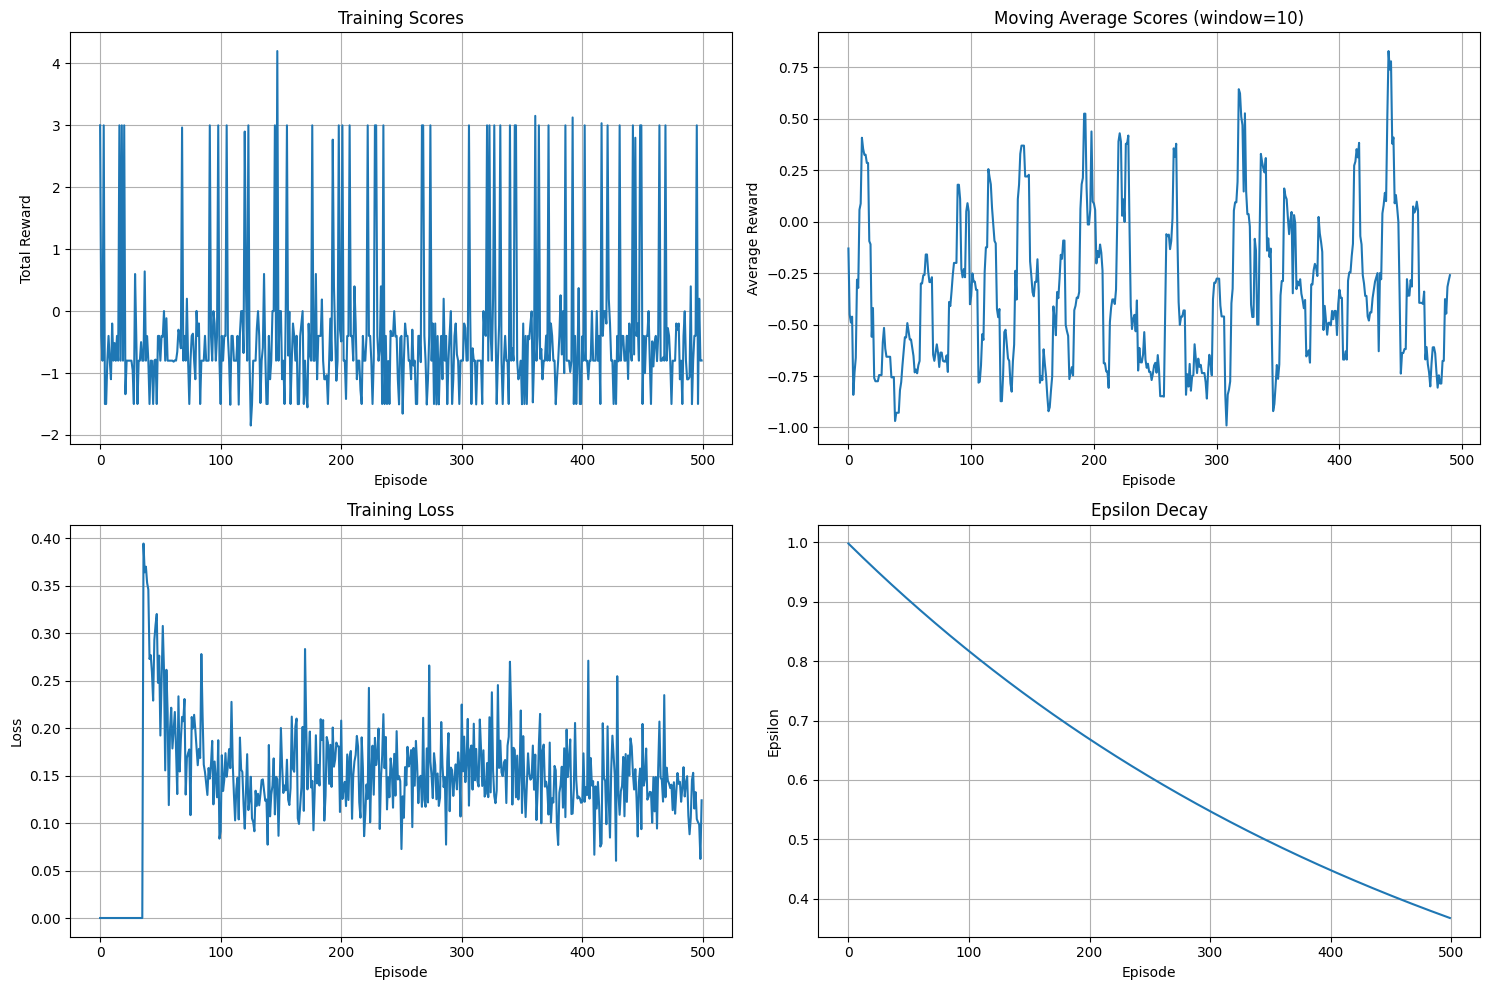


Evaluating final policy...
Average reward: -0.228
Standard deviation: 1.337
Action distribution:
  SHOOT: 435 (9.7%)
  PASS:  1342 (29.9%)
  MOVE:  2715 (60.4%)

DQN model saved as 'curry_dqn_model.keras'


In [36]:
# =============================================================================
# 5. DISPLAY RESULTS
# =============================================================================

# Plot training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scores
axes[0, 0].plot(scores)
axes[0, 0].set_title('Training Scores')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Moving average scores
window = 10
if len(scores) >= window:
    moving_avg = [np.mean(scores[i:i+window]) for i in range(len(scores)-window+1)]
    axes[0, 1].plot(moving_avg)
    axes[0, 1].set_title(f'Moving Average Scores (window={window})')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].grid(True)

# Losses
axes[1, 0].plot(losses)
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Epsilon decay
axes[1, 1].plot(epsilons)
axes[1, 1].set_title('Epsilon Decay')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate final policy
print("\nEvaluating final policy...")
total_rewards = []
action_counts = {0: 0, 1: 0, 2: 0}  # SHOOT, PASS, MOVE

for _ in range(1000):
    data_row = df.sample(1).iloc[0]
    state_dict = {
        'loc_x': data_row['LOC_X'],
        'loc_y': data_row['LOC_Y'],
        'time_remaining': data_row['Time_remaining'],
        'shot_clock': 24.0,
        'period': data_row['PERIOD'],
        'shot_prob': data_row['shot_prob'],
        'home': data_row['Home']
    }
    
    state = normalize_state(**state_dict)
    total_reward = 0
    steps = 0
    
    while steps < 50:
        # Greedy action selection
        state_batch = np.expand_dims(state, axis=0)
        q_values = q_network.predict(state_batch, verbose=0)
        action = np.argmax(q_values[0])
        action_counts[action] += 1
        
        next_state_dict, reward, done = step_environment(state_dict, action)
        total_reward += reward
        steps += 1
        
        if done:
            break
        
        state_dict = next_state_dict
        state = normalize_state(**state_dict)
    
    total_rewards.append(total_reward)

# Print evaluation results
print(f"Average reward: {np.mean(total_rewards):.3f}")
print(f"Standard deviation: {np.std(total_rewards):.3f}")
print(f"Action distribution:")
print(f"  SHOOT: {action_counts[0]} ({action_counts[0]/sum(action_counts.values())*100:.1f}%)")
print(f"  PASS:  {action_counts[1]} ({action_counts[1]/sum(action_counts.values())*100:.1f}%)")
print(f"  MOVE:  {action_counts[2]} ({action_counts[2]/sum(action_counts.values())*100:.1f}%)")

# Save model
q_network.save('curry_dqn_model.keras')
print("\nDQN model saved as 'curry_dqn_model.keras'")

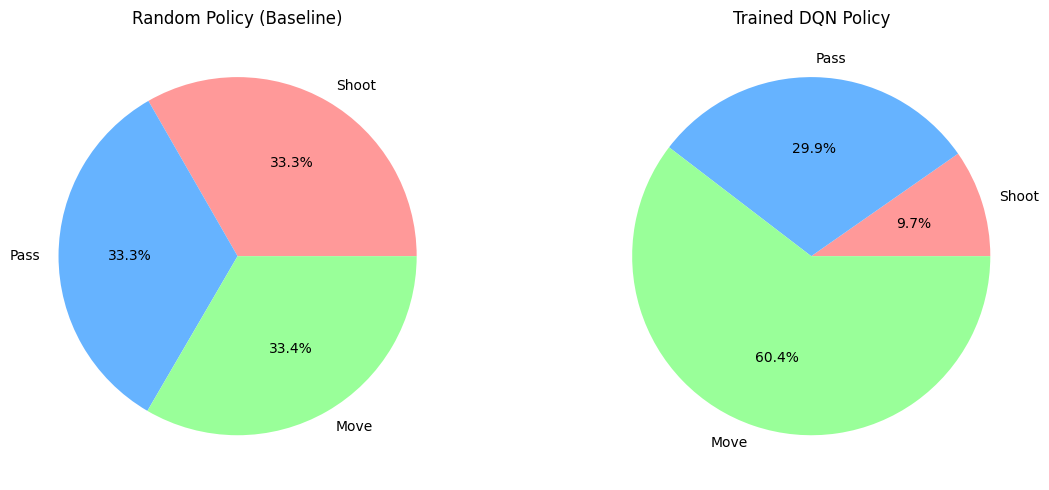

In [37]:
# Before and after training comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Random policy (baseline)
random_actions = [33.3, 33.3, 33.4]  # Equal distribution
action_labels = ['Shoot', 'Pass', 'Move']

ax1.pie(random_actions, labels=action_labels, autopct='%1.1f%%', 
        colors=['#ff9999', '#66b3ff', '#99ff99'])
ax1.set_title('Random Policy (Baseline)')

# Trained policy
trained_actions = [9.7, 29.9, 60.4]
ax2.pie(trained_actions, labels=action_labels, autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff', '#99ff99'])
ax2.set_title('Trained DQN Policy')

plt.tight_layout()
plt.show()

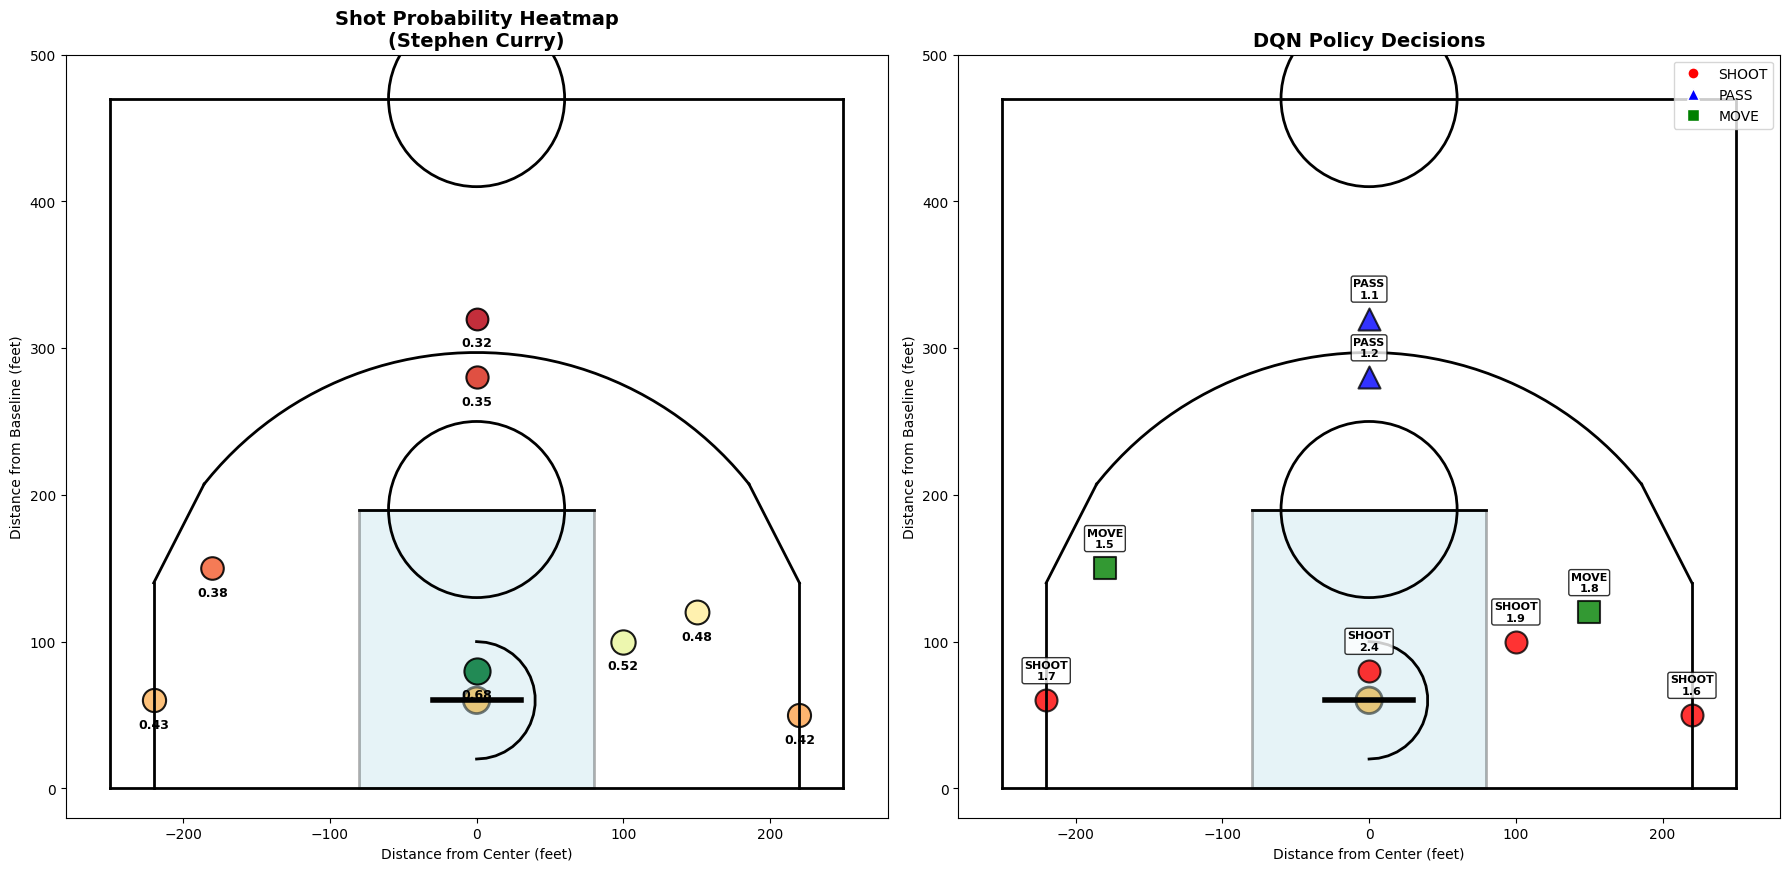

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_basketball_court(ax, color='black', lw=2):
    """Draw a half basketball court with correct NBA dimensions."""
    
    # Half court dimensions (we'll show offensive half)
    # Court is 94 feet long, 50 feet wide - we show 47 feet of length
    
    # Baseline (bottom of court)
    ax.plot([-250, 250], [0, 0], color=color, linewidth=lw)
    
    # Sidelines
    ax.plot([-250, -250], [0, 470], color=color, linewidth=lw)
    ax.plot([250, 250], [0, 470], color=color, linewidth=lw)
    
    # Half court line
    ax.plot([-250, 250], [470, 470], color=color, linewidth=lw)
    
    # Basket
    basket = patches.Circle((0, 60), 9, linewidth=lw, 
                          edgecolor=color, facecolor='orange', alpha=0.7)
    ax.add_patch(basket)
    
    # Backboard
    ax.plot([-30, 30], [60, 60], color=color, linewidth=lw*2)
    
    # Paint/Key (16 feet wide, 19 feet long)
    paint = patches.Rectangle((-80, 0), 160, 190, linewidth=lw,
                            edgecolor=color, facecolor='lightblue', alpha=0.3)
    ax.add_patch(paint)
    
    # Free throw line
    ax.plot([-80, 80], [190, 190], color=color, linewidth=lw)
    
    # Free throw circle
    ft_circle = patches.Circle((0, 190), 60, linewidth=lw, 
                             edgecolor=color, facecolor='none')
    ax.add_patch(ft_circle)
    
    # Three-point line
    # Corner threes are 22 feet from basket
    corner_3_distance = 220
    
    # Arc portion of 3-point line (23'9" = 237.5 inches from center of basket)
    theta = np.linspace(-0.9, 0.9, 50)  # Adjusted angle for realistic arc
    arc_radius = 237
    arc_x = arc_radius * np.sin(theta)
    arc_y = 60 + arc_radius * np.cos(theta)
    ax.plot(arc_x, arc_y, color=color, linewidth=lw)
    
    # Straight line portions in corners
    ax.plot([-corner_3_distance, -corner_3_distance], [0, 140], color=color, linewidth=lw)
    ax.plot([corner_3_distance, corner_3_distance], [0, 140], color=color, linewidth=lw)
    
    # Connect arc to corner lines
    ax.plot([-corner_3_distance, arc_x[0]], [140, arc_y[0]], color=color, linewidth=lw)
    ax.plot([corner_3_distance, arc_x[-1]], [140, arc_y[-1]], color=color, linewidth=lw)
    
    # Restricted area arc under basket
    restricted_theta = np.linspace(-np.pi/2, np.pi/2, 20)
    restricted_radius = 40
    restricted_x = restricted_radius * np.cos(restricted_theta)
    restricted_y = 60 + restricted_radius * np.sin(restricted_theta)
    ax.plot(restricted_x, restricted_y, color=color, linewidth=lw)
    
    # Center court circle (partial)
    center_circle = patches.Circle((0, 470), 60, linewidth=lw,
                                 edgecolor=color, facecolor='none')
    ax.add_patch(center_circle)

# Create cleaner visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Court 1: Shot Probability
draw_basketball_court(ax1)

positions = [
    [0, 80, 0.68, "Layup"],
    [150, 120, 0.48, "Mid-Range"],  
    [220, 50, 0.42, "Corner 3"],
    [0, 280, 0.35, "Top 3"],
    [-180, 150, 0.38, "Long 2"],
    [-220, 60, 0.43, "Corner 3"],
    [100, 100, 0.52, "Elbow"],
    [0, 320, 0.32, "Deep 3"],
]

for x, y, prob, desc in positions:
    size = 150 + (prob * 300)
    ax1.scatter(x, y, c=[prob], cmap='RdYlGn', s=size, 
               alpha=0.9, edgecolors='black', linewidth=1.5, vmin=0.3, vmax=0.7)
    ax1.annotate(f'{prob:.2f}', (x, y), xytext=(0, -20), 
                textcoords='offset points', fontsize=9, fontweight='bold',
                ha='center')

ax1.set_xlim(-280, 280)
ax1.set_ylim(-20, 500)
ax1.set_aspect('equal')
ax1.set_title('Shot Probability Heatmap\n(Stephen Curry)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from Center (feet)')
ax1.set_ylabel('Distance from Baseline (feet)')

# Court 2: Policy Decisions  
draw_basketball_court(ax2)

policy_data = [
    [0, 80, "SHOOT", 0.68, 2.4],
    [150, 120, "MOVE", 0.48, 1.8],
    [220, 50, "SHOOT", 0.42, 1.6],
    [0, 280, "PASS", 0.35, 1.2],
    [-180, 150, "MOVE", 0.38, 1.5],
    [-220, 60, "SHOOT", 0.43, 1.7],
    [100, 100, "SHOOT", 0.52, 1.9],
    [0, 320, "PASS", 0.32, 1.1],
]

colors = {'SHOOT': 'red', 'PASS': 'blue', 'MOVE': 'green'}
markers = {'SHOOT': 'o', 'PASS': '^', 'MOVE': 's'}

for x, y, action, prob, q_val in policy_data:
    ax2.scatter(x, y, c=colors[action], s=250, marker=markers[action],
               alpha=0.8, edgecolors='black', linewidth=1.5)
    ax2.annotate(f'{action}\n{q_val:.1f}', (x, y), xytext=(0, 15), 
                textcoords='offset points', fontsize=8, fontweight='bold',
                ha='center', bbox=dict(boxstyle="round,pad=0.2", 
                facecolor='white', alpha=0.8))

ax2.set_xlim(-280, 280)
ax2.set_ylim(-20, 500)
ax2.set_aspect('equal')
ax2.set_title('DQN Policy Decisions', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from Center (feet)')
ax2.set_ylabel('Distance from Baseline (feet)')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='SHOOT'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=8, label='PASS'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='MOVE')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()